In [1]:
import numpy as np
import Terms 
import celerite2
import matplotlib.pyplot as plt

In [2]:
def fn(x, sigma, t0):
    return np.exp(-(x - t0)**2 / (2 * sigma**2))

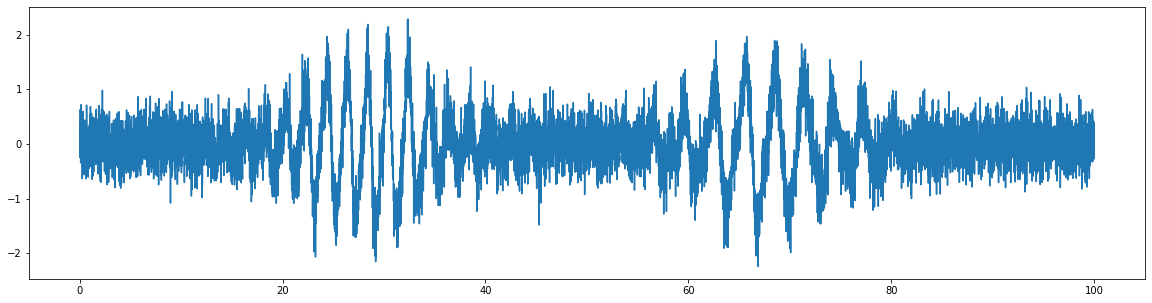

In [3]:
k1 = Terms.NSTerm(celerite2.terms.RotationTerm(f=0.5, Q0=100, dQ=0.0, period=2, sigma=1), lambda x: fn(x, 10, 30))
k2 = Terms.NSTerm(celerite2.terms.RotationTerm(f=0.5, Q0=100, dQ=0.0, period=3, sigma=1), lambda x: fn(x, 10, 70))

t = np.linspace(0, 100, 10000)
gp = celerite2.GaussianProcess(k1 + k2, t, diag=0.1)
y = gp.sample()

plt.figure(figsize=(20, 5))
plt.plot(t, y, '-')
plt.savefig('/Users/tgordon/Desktop/nonstationary_noisy.pdf')

In [7]:
from scipy.optimize import minimize

def buildgp(params):
    
    mean, diag, f1, Q01, dQ1, period1, sigma1, sigf1, tf1, f2, Q02, dQ2, period2, sigma2, sigf2, tf2 = params
    
    k1 = Terms.NSTerm(
        celerite2.terms.RotationTerm(
            f=f1, Q0=Q01, dQ=dQ1, period=period1, sigma=sigma1
        ), 
        lambda x: fn(x, sigf1, tf1)
    )
    k2 = Terms.NSTerm(
        celerite2.terms.RotationTerm(
            f=f2, Q0=Q02, dQ=dQ2, period=period2, sigma=sigma2
        ), 
        lambda x: fn(x, sigf2, tf2)
    )
    gp = celerite2.GaussianProcess(k1 + k2, t, mean=mean, diag=diag)
    return gp


def neg_log_like(params):
    try:
        gp = buildgp(params)
        ll = gp.log_likelihood(y)
    except:
        ll = -np.inf
    return -ll


initial_params = [0.0, 0.1, 0.5, 100, 0.0, 2, 1, 10, 30, 0.5, 100, 0.0, 3, 1, 10, 70]
soln = minimize(neg_log_like, initial_params)

      fun: 2860.4130025462555
 hess_inv: array([[ 1.74649906e-05, -2.11413597e-07, -5.61939250e-05,
        -2.42466185e-03, -4.84404594e-04,  4.31114009e-06,
        -7.12805365e-05, -2.35099806e-04, -3.55711288e-04,
        -1.00843916e-04, -3.17784067e-04,  8.50675898e-04,
         1.87877253e-05,  1.29021320e-04,  1.42135190e-04,
        -3.00865402e-05],
       [-2.11413597e-07,  2.05361625e-06,  5.51379866e-06,
         2.60114738e-04,  4.04785668e-05, -3.41779758e-07,
         3.99564212e-06,  1.14981985e-05,  3.39581260e-05,
         7.42106659e-06,  4.47372771e-05, -9.79320832e-05,
        -1.73890331e-06, -1.24056256e-05, -8.50694661e-06,
         1.29791089e-05],
       [-5.61939250e-05,  5.51379866e-06,  9.70472016e-03,
         8.79770543e-02,  9.65135175e-03,  1.05694936e-04,
        -2.15258092e-03, -3.19687456e-03,  1.01111788e-02,
         2.54246829e-03,  1.85661058e-02, -3.34215437e-02,
        -5.34715341e-04, -3.33263914e-03, -4.10347004e-03,
         2.66513489e-0

In [8]:
import emcee

def prior(params):
    
    mean, diag, f1, Q01, dQ1, period1, sigma1, sigf1, tf1, f2, Q02, dQ2, period2, sigma2, sigf2, tf2 = params
    
    if ((period1 > 0) 
        & (period2 > 0) 
        & (sigf1 > 0) 
        & (sigf2 > 0) 
        & (diag > 0) 
        & (f1 > 0) 
        & (f2 > 0) 
        & (sigma1 > 0) 
        & (sigma2 > 0)
       ):
        return 0.0
    else:
        return -np.inf
    

def log_prob(params):
    
    pr = prior(params)
    if pr == 0.0:
        gp = buildgp(params)
        ll = gp.log_likelihood(y)
        if not np.isnan(ll):
            return ll
        else:
            return - np.inf
    else:
        return -np.inf

In [9]:
coords = soln.x + 1e-5 * np.random.randn(64, len(soln.x))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob
)
state = sampler.run_mcmc(coords, 1000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 1000, progress=True)

 53%|█████▎    | 534/1000 [03:13<02:33,  3.03it/s]/usr/local/lib/python3.8/site-packages/celerite2/terms.py:798: RuntimeWarning: invalid value encountered in sqrt
  w1 = 4 * np.pi * Q1 / (self.period * np.sqrt(4 * Q1 ** 2 - 1))
 54%|█████▍    | 539/1000 [03:15<02:43,  2.82it/s]/usr/local/lib/python3.8/site-packages/celerite2/terms.py:803: RuntimeWarning: invalid value encountered in sqrt
  w2 = 8 * np.pi * Q2 / (self.period * np.sqrt(4 * Q2 ** 2 - 1))
100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
some_params_samples = flat_samples[:, [5, 7, 8, 12, 14, 15]]
labels=[r'$P_1$', r'$\sigma_1$', r'$\mu_1$', r'$P_2$', r'$\sigma_2$', r'$\mu_2$']
truths = [2, 10, 30, 3, 10, 70]

fig = corner.corner(some_params_samples, labels=labels, truths=truths);
plt.savefig('/Users/tgordon/Desktop/nonstationary_corner_noisy.pdf')